<a href="https://colab.research.google.com/github/gshah8/UCF/blob/master/Machine_Learning/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 2

The goal of this homework is to create a convolutional neural network for the CIFAR10 data set. 
See [this colab notebook](https://colab.research.google.com/drive/1LZZviWOzvchcXRdZi2IBx3KOpQOzLalf) how to load the CIFAR data in Keras.

You should not use any pretrained convnets that come with Keras. You have to create and train your own convnets with Keras from scratch.

## Simple hold-out validation

Make sure that the data is divided into: 

- training set (80%)
- validation set (20%)
- test set. 

Use the training set to train your neural networks. Evaluate their performance on the validation data set. 

After trying several different architectures, choose the one that performs
best of the validation set. Try at least four different architectures by using data augmentation, using dropout, varying the number of layers, the number of filters, etc.

Train this final architecture on the data from the training set and validation set and evaluate its performance on 
the test set.

## k-fold validation

Reevaluate your best architecture using k-fold validation with k=5, that is, the size of the validation fold is 20%. Does the accuracy/loss obtain by k-fold validation differ from the accuracy/loss obtain by simple hold-out validation.

### Load the CIFAR10 data set



In [1]:
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils


(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

Using TensorFlow backend.


170500096/170498071 [==============================] - 175s 1us/step


### Explore the format of the CIFAR10 data set

In [2]:
train_images.shape

(50000, 32, 32, 3)

In [3]:
train_images.ndim

4

In [4]:
train_labels.shape

(50000, 1)

In [5]:
train_labels.ndim

2

###Simple Hold Validation for the models below

In [6]:
#divide training data into training and validation data
rand_idx = np.random.permutation(len(train_images))
val_idx = rand_idx[0:10000]
train_idx = rand_idx[10000:]

train_images_new, train_labels_new = train_images[train_idx] , train_labels[train_idx]
val_images, val_labels = train_images[val_idx] , train_labels[val_idx]

print(train_labels_new[0])

[5]


###Normalize train, validation and test data




In [7]:
#normalize
train_images_norm = (train_images_new/255).astype('float32')
val_images_norm = (val_images/255).astype('float32')
test_images_norm = (test_images/255).astype('float32')

#one-hot encoding
train_labels_norm = to_categorical(train_labels_new)
val_labels_norm = to_categorical(val_labels)
test_labels_norm = to_categorical(test_labels)

print(train_labels_norm[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


###Build a basic model (without regularization and data augmentation)

In [9]:
# set up the layers

model = models.Sequential()
#conv layers   
#1
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
#2
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
#3
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
#dense layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
__________

In [0]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [11]:
epochs = 20
history = model.fit(train_images_norm, 
                      train_labels_norm, 
                      epochs=epochs, 
                      batch_size=64, 
                      validation_data=(val_images_norm, val_labels_norm))

Instructions for updating:
Use tf.cast instead.
Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 13s 316us/step - loss: 1.5815 - acc: 0.4276 - val_loss: 1.3115 - val_acc: 0.5238
Epoch 2/20
40000/40000 [==============================] - 8s 195us/step - loss: 1.1898 - acc: 0.5784 - val_loss: 1.0927 - val_acc: 0.6217
Epoch 3/20
40000/40000 [==============================] - 8s 196us/step - loss: 1.0071 - acc: 0.6487 - val_loss: 1.0335 - val_acc: 0.6364
Epoch 4/20
40000/40000 [==============================] - 8s 197us/step - loss: 0.9048 - acc: 0.6846 - val_loss: 0.9386 - val_acc: 0.6726
Epoch 5/20
40000/40000 [==============================] - 8s 195us/step - loss: 0.8213 - acc: 0.7162 - val_loss: 0.8847 - val_acc: 0.6927
Epoch 6/20
40000/40000 [==============================] - 8s 196us/step - loss: 0.7595 - acc: 0.7376 - val_loss: 0.8928 - val_acc: 0.6895
Epoch 7/20
40000/40000 [==============================] - 8s 197us/step -

We can observe that the model is clearly overfitted since the training accuracy is increasing as we increase the number of epochs but the validation accuracy is not increasing.

Now, we will try to improve the model by using the four following architectures:
1. Add another convolutional layer
2. Data Augmentation
3. Regularization - Dropout
4. Regularization - Batch Normalization
5. Strides

We will add the above mentioned architectures one by one and observe the training and validation accuracy.
In the end, as a final check, we will run the model for test data.

###Add another convolutional layer

In [12]:
# set up the layers

model = models.Sequential()
#conv layers   
#1
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
#2
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
#3
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
#4
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
#dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 128)         147584    
__________

In [0]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [14]:
epochs = 40
history = model.fit(train_images_norm, 
                      train_labels_norm, 
                      epochs=epochs, 
                      batch_size=64, 
                      validation_data=(val_images_norm, val_labels_norm))

Train on 40000 samples, validate on 10000 samples
Epoch 1/40
40000/40000 [==============================] - 13s 320us/step - loss: 1.5315 - acc: 0.4386 - val_loss: 1.1855 - val_acc: 0.5765
Epoch 2/40
40000/40000 [==============================] - 12s 307us/step - loss: 1.0776 - acc: 0.6172 - val_loss: 0.9951 - val_acc: 0.6434
Epoch 3/40
40000/40000 [==============================] - 12s 307us/step - loss: 0.8594 - acc: 0.6993 - val_loss: 0.8426 - val_acc: 0.7057
Epoch 4/40
40000/40000 [==============================] - 12s 307us/step - loss: 0.7226 - acc: 0.7481 - val_loss: 0.8352 - val_acc: 0.7143
Epoch 5/40
40000/40000 [==============================] - 12s 304us/step - loss: 0.6211 - acc: 0.7825 - val_loss: 0.7482 - val_acc: 0.7410
Epoch 6/40
40000/40000 [==============================] - 12s 302us/step - loss: 0.5231 - acc: 0.8160 - val_loss: 0.7746 - val_acc: 0.7406
Epoch 7/40
40000/40000 [==============================] - 12s 304us/step - loss: 0.4426 - acc: 0.8442 - val_loss: 0.

Adding another layer doesn't increase validation accuracy.There is even more overfitting since the training accuracy is around 98% for the 40th epoch whereas it is just around 75% for validation data.

Therefore, now we are going to include regularization, data augmentation and dropout one by one to the existing model with 4 layers in order to see how to validation accuracy improves and overfitting is minimized.

###Add Data Augmentation

In [15]:
# set up the layers

model = models.Sequential()
#conv layers   
#1
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
#2
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
#3
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
#4
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
#dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 128)         147584    
__________

In [0]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [17]:
epochs = 40
datagen = ImageDataGenerator(
    #rescale=1./255,  #our image is already normalized so we dont need this
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(train_images_norm)

history = model.fit_generator(datagen.flow(train_images_norm, train_labels_norm, batch_size=64),
                    steps_per_epoch=int(len(train_images_norm) / 64), epochs=epochs,
                   verbose=1, validation_data=(val_images_norm, val_labels_norm))

Epoch 1/40
625/625 [==============================] - 29s 47ms/step - loss: 1.8152 - acc: 0.3275 - val_loss: 1.6358 - val_acc: 0.4227
Epoch 2/40
625/625 [==============================] - 28s 45ms/step - loss: 1.5297 - acc: 0.4442 - val_loss: 1.2595 - val_acc: 0.5430
Epoch 3/40
625/625 [==============================] - 28s 45ms/step - loss: 1.3918 - acc: 0.4975 - val_loss: 1.1232 - val_acc: 0.5886
Epoch 4/40
625/625 [==============================] - 28s 45ms/step - loss: 1.3051 - acc: 0.5313 - val_loss: 1.2593 - val_acc: 0.5589
Epoch 5/40
625/625 [==============================] - 28s 45ms/step - loss: 1.2511 - acc: 0.5555 - val_loss: 1.0172 - val_acc: 0.6355
Epoch 6/40
625/625 [==============================] - 28s 45ms/step - loss: 1.1841 - acc: 0.5769 - val_loss: 1.0580 - val_acc: 0.6244
Epoch 7/40
625/625 [==============================] - 28s 46ms/step - loss: 1.1472 - acc: 0.5904 - val_loss: 0.9873 - val_acc: 0.6492
Epoch 8/40
625/625 [==============================] - 29s 46ms

###Add more Layers, Regularization (kernal_regularizer, batch normalization and dropout) and Strides

In [23]:
#from keras import regularizers
# set up the layers
weight_decay = 1e-4
model = models.Sequential()
#conv layers   
#1
model.add(layers.Conv2D(32, (3, 3), strides = (1,1), activation='relu', padding = 'same', kernel_initializer='he_normal', kernel_regularizer= regularizers.l2(weight_decay), input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
#2
model.add(layers.Conv2D(32, (3, 3), strides = (1,1), activation='relu', padding = 'same', kernel_initializer='he_normal', kernel_regularizer= regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
#3
model.add(layers.Conv2D(64, (3, 3), strides = (1,1), activation='relu',padding = 'same', kernel_initializer='he_normal', kernel_regularizer= regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
#4
model.add(layers.Conv2D(64, (3, 3), strides = (1,1), activation='relu', padding = 'same', kernel_initializer='he_normal', kernel_regularizer= regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
#5
model.add(layers.Conv2D(128, (3, 3), strides = (1,1), activation='relu', padding = 'same', kernel_initializer='he_normal', kernel_regularizer= regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
#6
model.add(layers.Conv2D(128, (3, 3), strides = (1,1), activation='relu', padding = 'same', kernel_initializer='he_normal', kernel_regularizer= regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
#dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 16, 64)        18496     
__________

In [0]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [25]:
epochs = 80
history = model.fit(train_images_norm, 
                      train_labels_norm, 
                      epochs=epochs, 
                      batch_size=64, 
                      validation_data=(val_images_norm, val_labels_norm))

Train on 40000 samples, validate on 10000 samples
Epoch 1/80
40000/40000 [==============================] - 40s 990us/step - loss: 1.9697 - acc: 0.3159 - val_loss: 1.6191 - val_acc: 0.4530
Epoch 2/80
40000/40000 [==============================] - 36s 893us/step - loss: 1.5549 - acc: 0.4670 - val_loss: 1.2118 - val_acc: 0.5975
Epoch 3/80
40000/40000 [==============================] - 35s 886us/step - loss: 1.3383 - acc: 0.5577 - val_loss: 1.1041 - val_acc: 0.6389
Epoch 4/80
40000/40000 [==============================] - 33s 833us/step - loss: 1.1949 - acc: 0.6199 - val_loss: 0.9870 - val_acc: 0.6864
Epoch 5/80
40000/40000 [==============================] - 28s 692us/step - loss: 1.0926 - acc: 0.6594 - val_loss: 0.8855 - val_acc: 0.7246
Epoch 6/80
40000/40000 [==============================] - 35s 863us/step - loss: 1.0127 - acc: 0.6920 - val_loss: 0.8591 - val_acc: 0.7478
Epoch 7/80
40000/40000 [==============================] - 35s 875us/step - loss: 0.9643 - acc: 0.7110 - val_loss: 0.

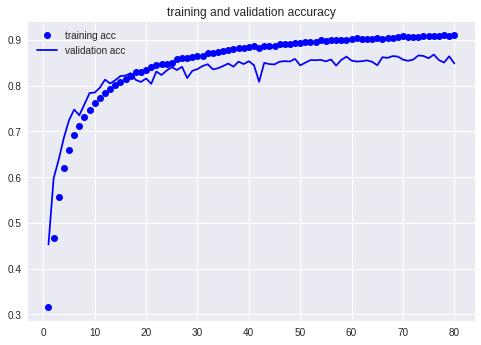

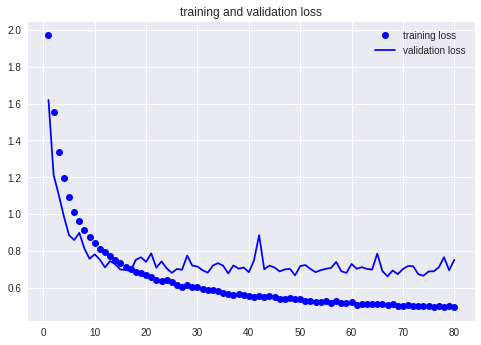

In [26]:
#print(epochs)
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

###Model Performance on Test data using simple hold validation

In [28]:
result = model.evaluate(test_images_norm, test_labels_norm, verbose=1)
print('Test accuracy:', result[1])
print('Test loss:', result[0])

10000/10000 [==============================] - 3s 259us/step
Test accuracy: 0.8448
Test loss: 0.7580705450057983


###K-fold validation 